# Grad-CAM Analysis for Plant Disease Detection Models

This notebook demonstrates the application of Grad-CAM (Gradient-weighted Class Activation Mapping) on two models used in plant disease detection: **ResTS** (Teacher-Student architecture) and **EfficientNetB0**. Grad-CAM helps visualize which regions in an image contribute most to the model's decision, enhancing model interpretability.

In [6]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tf_explain.core.grad_cam import GradCAM  # Only for EfficientNetB0

In [7]:
# Check if GPU is available:
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
tf.config.optimizer.set_jit(False)  # Enable XLA for potential performance improvement

TensorFlow version: 2.4.1
GPU is available


In [8]:
# Loadig pre-trained models:
ResTS_model = tf.keras.models.load_model('../models/ResTS_trained_model')
EfficientNetB0_model = tf.keras.models.load_model('../models/EfficientNetB0_trained_model.h5')

In [9]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """
    Loads an image and preprocesses it to the target size.
    
    Args:
        img_path (str): Path to the input image.
        target_size (tuple): Target size for the image (default: (224, 224)).
        
    Returns:
        tuple: Original image and preprocessed image array.
    """
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img, tf.keras.applications.xception.preprocess_input(img_array)


In [10]:
def compute_gradcam(model, img_array, layer_name, output_index=0):
    """
    Computes the Grad-CAM heatmap for a specific output of the ResTS model.
    
    Args:
        model (tf.keras.Model): The ResTS model.
        img_array (numpy.ndarray): Preprocessed image.
        layer_name (str): Name of the convolutional layer to visualize.
        output_index (int): Index of the model output (Teacher or Student).
        
    Returns:
        numpy.ndarray: Grad-CAM heatmap.
    """
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.outputs[output_index]])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])  # Class index of the highest probability
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    cam = np.zeros(conv_outputs.shape[:2], dtype=np.float32)

    for i, w in enumerate(pooled_grads):
        cam += w * conv_outputs[:, :, i]
    
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    
    return cam

In [11]:
def overlay_gradcam(img, cam, alpha=0.6):
    """
    Overlays the Grad-CAM heatmap on the original image.
    
    Args:
        img (PIL.Image): Original image.
        cam (numpy.ndarray): Grad-CAM heatmap.
        alpha (float): Transparency factor for overlay.
        
    Returns:
        numpy.ndarray: Image with Grad-CAM overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlayed_img = cv2.addWeighted(np.array(img).astype(np.uint8), alpha, heatmap, 1 - alpha, 0)
    return overlayed_img

In [12]:
def apply_gradcam_resTS(model, img_path, layer_name, output_index=0, model_type="ResTS", save_name="gradcam_result_resTS.png"):
    """
    Applies Grad-CAM to the ResTS model.
    
    Args:
        model (tf.keras.Model): ResTS model.
        img_path (str): Path to the image.
        layer_name (str): Layer name for Grad-CAM computation.
        output_index (int): Output index (Teacher or Student).
        model_type (str): Type of model part (Teacher or Student).
    """
    img, img_array = load_and_preprocess_image(img_path)
    cam = compute_gradcam(model, img_array, layer_name, output_index=output_index)
    overlayed_img = overlay_gradcam(img, cam, alpha=0.6)
    
    plt.imshow(overlayed_img)
    plt.axis('off')
    plt.title(f"Grad-CAM for {model_type} - Output {output_index}")
    plt.show()

    # Save the image
    plt.imsave(os.path.join("../images", save_name), overlayed_img)

In [13]:
def apply_gradcam_efficientnet(model, img_path, layer_name="top_conv", save_name="gradcam_result_efficientnet.png"):
    """
    Applies Grad-CAM using the tf-explain library on the EfficientNet model.

    Args:
        model (tf.keras.Model): The EfficientNet model.
        img_path (str): Path to the input image.
        layer_name (str): Layer name for Grad-CAM computation.
    """
    grad_cam = GradCAM()

    # Load and preprocess the image
    img, img_array = load_and_preprocess_image(img_path, target_size=(224, 224))

    # Predict and get the class index
    predictions = model.predict(img_array)
    class_index = int(np.argmax(predictions))

    # Get Grad-CAM explanation directly from tf-explain
    explanation = grad_cam.explain(
        validation_data=(img_array, None),
        model=model,
        class_index=class_index,
        layer_name=layer_name
    )

    # Normalize and threshold the Grad-CAM explanation for better visualization
    explanation = (explanation - explanation.min()) / (explanation.max() - explanation.min())
    explanation[explanation < 0.3] = 0  # Apply threshold to emphasize high-activation regions

    # Display the result as produced by tf-explain (no additional normalization)
    plt.imshow(explanation)
    plt.axis('off')
    plt.title("Grad-CAM for EfficientNetB0")
    plt.show()
    # Save the image
    plt.imsave(os.path.join("../images", save_name), explanation)

ResTS Grad-CAM (Teacher Head):


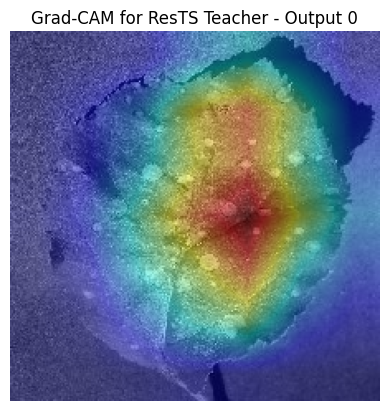

ResTS Grad-CAM (Student Head):


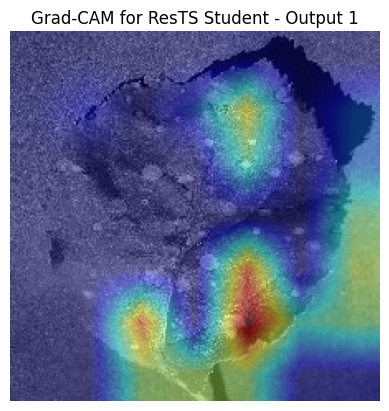

EfficientNetB0 Grad-CAM:


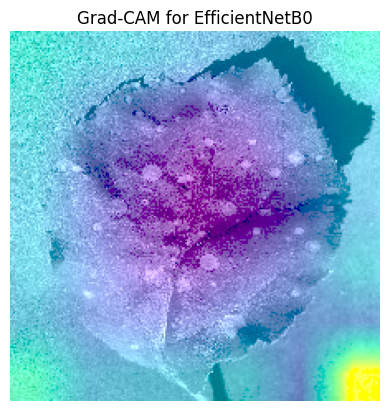

In [15]:
# Path to test image
img_path = '../data/test/Apple___Black_rot/47f6d143-687b-4755-88a0-932c985a2ee6___JR_FrgE.S 2785.JPG'

# Apply and save Grad-CAM for ResTS (Teacher Output)
print("ResTS Grad-CAM (Teacher Head):")
apply_gradcam_resTS(ResTS_model, img_path, layer_name="block14_sepconv2_act", output_index=0, model_type="ResTS Teacher", save_name="gradcam_resTS_teacher.png")

# Apply and save Grad-CAM for ResTS (Student Output)
print("ResTS Grad-CAM (Student Head):")
apply_gradcam_resTS(ResTS_model, img_path, layer_name="block14_sepconv2_act", output_index=1, model_type="ResTS Student", save_name="gradcam_resTS_student.png")

# Apply and save Grad-CAM for EfficientNetB0
print("EfficientNetB0 Grad-CAM:")
apply_gradcam_efficientnet(EfficientNetB0_model, img_path, layer_name="top_conv", save_name="gradcam_efficientnet.png")

## Conclusion
In this notebook, we demonstrated Grad-CAM application on two distinct architectures. While tf-explain library supported EfficientNetB0 well, ResTS required a customized approach. This is due to ResTS’s multi-output structure, where each output (Teacher and Student) has distinct prediction branches. The tf-explain library does not natively handle such multi-head architectures, which led to the development of custom Grad-CAM functions for ResTS.